<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5410_HW1_P4_BO_LCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-5-11234a72ca04>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return ((x-0.6) ** 2 + x ** 2 * cos(5 * pi * x) ** 6.0) + noise


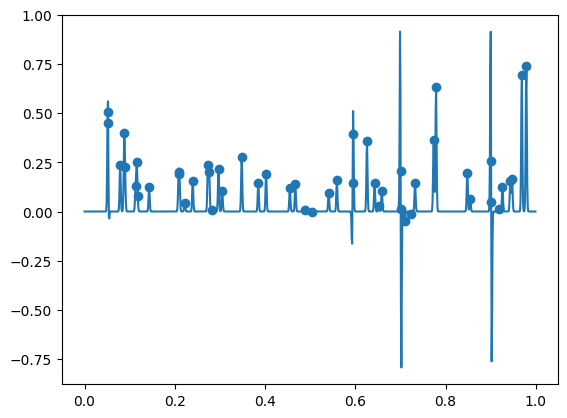

>x=0.715, f()=-0.000, actual=-0.001
>x=0.705, f()=-0.020, actual=0.267
>x=0.902, f()=-0.761, actual=0.187
>x=0.500, f()=-0.000, actual=-0.064
>x=0.589, f()=-0.000, actual=0.378
>x=0.055, f()=-0.007, actual=0.146
>x=0.195, f()=0.000, actual=0.155
>x=0.721, f()=-0.000, actual=0.079
>x=0.712, f()=-0.001, actual=0.001
>x=0.702, f()=-0.302, actual=-0.095


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The opti

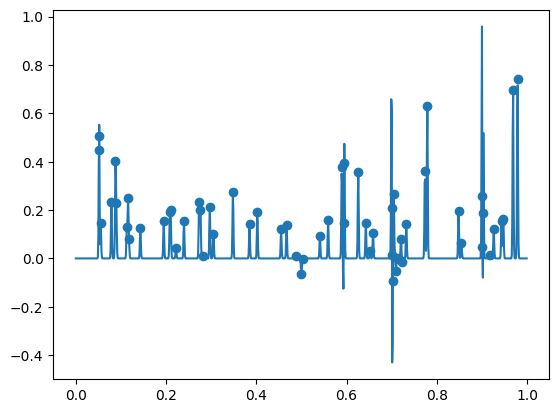

Best Result: x=0.702, y=-0.095


In [5]:
from math import sin, cos
from math import pi
from numpy import arange, vstack, argmin, asarray
from numpy.random import normal, random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from warnings import catch_warnings, simplefilter
from matplotlib import pyplot

# objective function
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return ((x-0.6) ** 2 + x ** 2 * cos(5 * pi * x) ** 6.0) + noise

# surrogate function
def surrogate(model, X):
    with catch_warnings():
        simplefilter("ignore")
        return model.predict(X, return_std=True)

# LCB (lower confidence bound) acquisition function
def acquisition(X, Xsamples, model, kappa=1.96):
    mu, std = surrogate(model, Xsamples)
    scores = mu - kappa * std
    return scores

# optimize the acquisition function
def opt_acquisition(X, y, model):
    Xsamples = random(100).reshape(-1, 1)
    scores = acquisition(X, Xsamples, model)
    ix = argmin(scores)
    return Xsamples[ix, 0]

# plot function
def plot(X, y, model, img_name):
    pyplot.scatter(X, y)
    Xsamples = asarray(arange(0, 1, 0.001)).reshape(-1, 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    pyplot.show()
    pyplot.close()

# sample the domain sparsely with noise
X = random(50).reshape(-1, 1)
y = asarray([objective(x) for x in X]).reshape(-1, 1)

# Define the model with refined parameters
kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-2, 10.0))
model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=2)
model.fit(X, y)

# plot before optimization
plot(X, y, model, img_name='gp_initial_model')

# perform the optimization process
num_iterations = 10
for i in range(num_iterations):
    x = opt_acquisition(X, y, model)
    actual = objective(x)
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%.3f, actual=%.3f' % (x, est[0], actual))
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    model.fit(X, y)

# plot final result
plot(X, y, model, img_name='gp_result_model')

# best result
ix = argmin(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix].item(), y[ix].item()))